In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import ast
import seaborn as sns
import numpy as np
from sklearn import decomposition
from sklearn.cluster import KMeans, DBSCAN
from helpers import *

In [237]:
# conda install -c plotly plotly=5.11.0
# conda install -c conda-forge jupyterlab-plotly-extension
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#pio.renderers.default = 'jupyterlab'
#plotly.offline.init_notebook_mode(connected=True)

## Clustering

Let's import the data set that we are going to use for the analysis in this notebook.

In [238]:
df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t',low_memory=False)

In [239]:
columns_character = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth',
                     'Actor gender', 'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 'Actor name',
                     'Actor age at movie release', 'Freebase character/actor map ID', 'Freebase character ID',
                     'Freebase actor ID']

df_character = pd.read_csv("MovieSummaries/character.metadata.tsv",sep='\t',names=columns_character)

#df_mapID = pd.read_csv("Expanded_data/mid2name.tsv", sep='\t', names=['ID', 'label'])
#df_mapID = df_mapID.drop_duplicates(subset=["ID"], keep='first')
#ethnicity = df_character['Actor ethnicity (Freebase ID)']
#df_ethnicity = ethnicity.to_frame()
#df_ethnicity.columns = ['ID']
#df_merge = pd.merge(df_ethnicity, df_mapID, how='left')
#df_character['Ethnicity'] = df_merge['label']

In [240]:
df_movie.head()

,Freebase movie ID,IMDB_id,Movie box office revenue,Movie genres names,Movie name,Movie release date,averageRating,budget,numVotes,prod_country,inflation coeff,inflation corrected revenue,inflation corrected budget
0,/m/0100_m55,tt0138297,NaN,"['Comedy', 'Sci-Fi']",Urban Animals,1987.0,5.2,NaN,79.0,NaN,2.384772,NaN,NaN
1,/m/0100_mnm,tt0202813,NaN,['Comedy'],NaN,1999.0,5.8,NaN,15.0,NaN,1.626713,NaN,NaN
2,/m/0100_nzr,tt0184302,NaN,['Drama'],NaN,1999.0,4.8,NaN,119.0,NaN,1.626713,NaN,NaN
3,/m/0100_pgp,tt0094831,NaN,['Comedy'],NaN,1988.0,6.8,NaN,103.0,NaN,2.291337,NaN,NaN
4,/m/0100_pz9,tt0088884,NaN,['Comedy'],NaN,1985.0,2.4,NaN,59.0,NaN,2.519087,NaN,NaN


### 1) Preprocessing

As we want to do clustering we have to create a big matrix with many features to reduce. 

In [241]:
data = df_movie[['Freebase movie ID', 'Movie genres names', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue', 'prod_country']].dropna()

First, we incorporated the movie genres as dummy variable :

In [242]:
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
data, genre_names = incorporate_genre_dummies(data)
data = data.drop(columns = ['Movie genres names'])

In [243]:
data.iloc[:,5:27].sum() 

Action         1141
Adventure       726
Animation        29
Biography       251
Comedy         1563
Crime           862
Documentary      27
Drama          2135
Family          219
Fantasy         363
History         136
Horror          440
Music           143
Musical          52
Mystery         410
News              2
Romance         779
SciFi           353
Sport           105
Thriller        717
War              86
Western          40
dtype: int64

We decided to drop the News feature as only very few movies are in this categorie :

In [244]:
data = data.drop(columns = ['News'])

There are also music and musical genres, we can join these two features in one :

In [245]:
data['Music'] = np.logical_or(data['Music'], data['Musical']).sum()
data = data.drop(columns = ['Musical'])

Then, we can also incorporate the production country as dummy variables, but we take into account only the countries that have 10 movies and more :

In [246]:
cutoff_country_list = (data.groupby('prod_country').count()['Freebase movie ID'] < 10) 
cutoff_country_list = list(cutoff_country_list[cutoff_country_list].index)

In [247]:
data = pd.get_dummies(data, prefix='', prefix_sep='', columns=['prod_country'])
data = data.drop(columns = cutoff_country_list)

We rename columns and take the log of the inflation corrected revenue and budget to get a more gaussian-like distribution :

In [248]:
data.rename(columns={'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)
data['log_revenue'] = np.log(data['corr_revenue'])
data['log_budget'] = np.log(data['corr_budget'])
data = data.drop(columns = ['corr_revenue', 'corr_budget'])

Then, we decided to incoporate some information about the actors of the movies :

In [249]:
# Not display the warnings, even if we used .loc the warnings are still there
pd.options.mode.chained_assignment = None

def add_actor_mean_age(x) :
    tmp = df_character[df_character['Freebase movie ID'] == x]
    return tmp['Actor age at movie release'].mean()
    
def add_actor_mean_height(x) :
    tmp = df_character[df_character['Freebase movie ID'] == x]
    return tmp['Actor height (in meters)'].mean()

def add_actor_frac_men(x) : 
    tmp = df_character[df_character['Freebase movie ID'] == x]
    men = (tmp['Actor gender'] == 'M').sum()
    women = (tmp['Actor gender'] == 'F').sum()
    if (men + women) == 0 : 
        return float('NaN')
    return men / (men + women)
    

data['mean_age'] = data['Freebase movie ID'].apply(lambda x : add_actor_mean_age(x))
data['mean_height'] = data['Freebase movie ID'].apply(lambda x : add_actor_mean_height(x))
data['fraction_men'] = data['Freebase movie ID'].apply(lambda x : add_actor_frac_men(x))

In [250]:
data = data.dropna(subset=['mean_age', 'mean_height', 'fraction_men'])

We displayed the distribition of these three new features to see if some transformations are required :

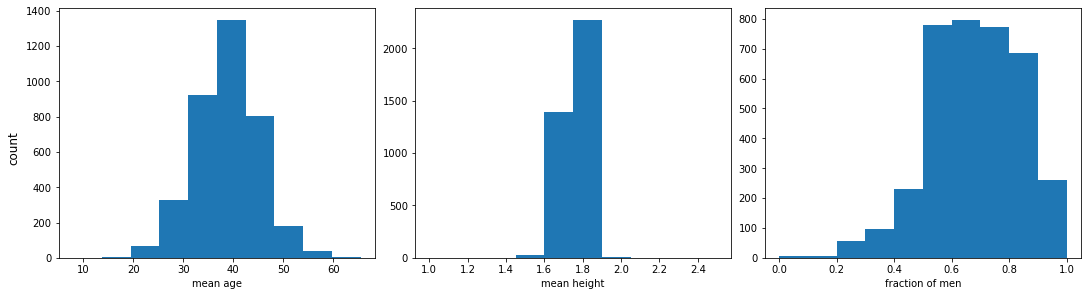

In [251]:
fig, ax = plt.subplots(1,3,constrained_layout=True, figsize=(15, 4))
ax[0].hist(data['mean_age'])
ax[0].set_xlabel('mean age')
ax[1].hist(data['mean_height'], range=[1,2.5])
ax[1].set_xlabel('mean height')
ax[2].hist(data['fraction_men'])
ax[2].set_xlabel('fraction of men')
fig.supylabel('count')
plt.show()

The new features do not require to be log transformed, as there are nearly gaussian-like.

Finally, we can remove the Freebase movie ID, as we map all the data that we wanted to the movies :

In [252]:
data = data.drop(columns=['Freebase movie ID'])

In [253]:
print(data.shape)
data.head(3)

(3688, 41)


,averageRating,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,JP,KR,NZ,RU,US,log_revenue,log_budget,mean_age,mean_height,fraction_men
3690,7.7,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,19.108610,18.850228,36.888889,1.752714,0.666667
3850,8.1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,18.708726,17.125548,37.600000,1.861667,0.705882
3853,7.2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,19.704512,18.846162,33.875000,1.752857,0.705882


### 2) Separation into 4 groups according to budget and rating

We decided to separate the data into high, low budget and high, low rating categories. We took the 0.25 and 0.75 percentiles as cutoff.

In [254]:
data_HR_LB = data[np.logical_and(data['averageRating'] > data['averageRating'].quantile(0.75), data['log_budget'] < data['log_budget'].quantile(0.25))]
data_HR_HB = data[np.logical_and(data['averageRating'] > data['averageRating'].quantile(0.75), data['log_budget'] > data['log_budget'].quantile(0.75))]
data_LR_LB = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.25), data['log_budget'] < data['log_budget'].quantile(0.25))]
data_LR_HB = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.25), data['log_budget'] > data['log_budget'].quantile(0.75))]

print(data_HR_LB.shape)
print(data_HR_HB.shape)
print(data_LR_LB.shape)
print(data_LR_HB.shape)

(268, 41)
(206, 41)
(193, 41)
(214, 41)


We can interestingly see that there are more movies that have a high average rating and a low budget compare to the other categories. We have to do more analyses to conclude even if we took the same cutoff for all the categories.

First, we can inveatigate the genres of these categories (columns 1 to 20) :

In [255]:
data_HR_LB_genres = data_HR_LB.iloc[:,1:21]
data_HR_HB_genres = data_HR_HB.iloc[:,1:21]
data_LR_HB_genres = data_LR_HB.iloc[:,1:21]
data_LR_LB_genres = data_LR_LB.iloc[:,1:21]

In [256]:
#total_count = data_HR_LB_genres.sum().values + data_HR_HB_genres.sum().values + data_LR_HB_genres.sum().values + data_LR_LB_genres.sum().values

#### Jsp quel total count prendre ? celui sur les data entières ou celui sur la sum ce qu'il y a des les 4 groupes ? Je pensais plutot celui sur les data entière mais apres ca somme pas jusqu'a 1 parce des films entrent dans aucune des 4 categories 

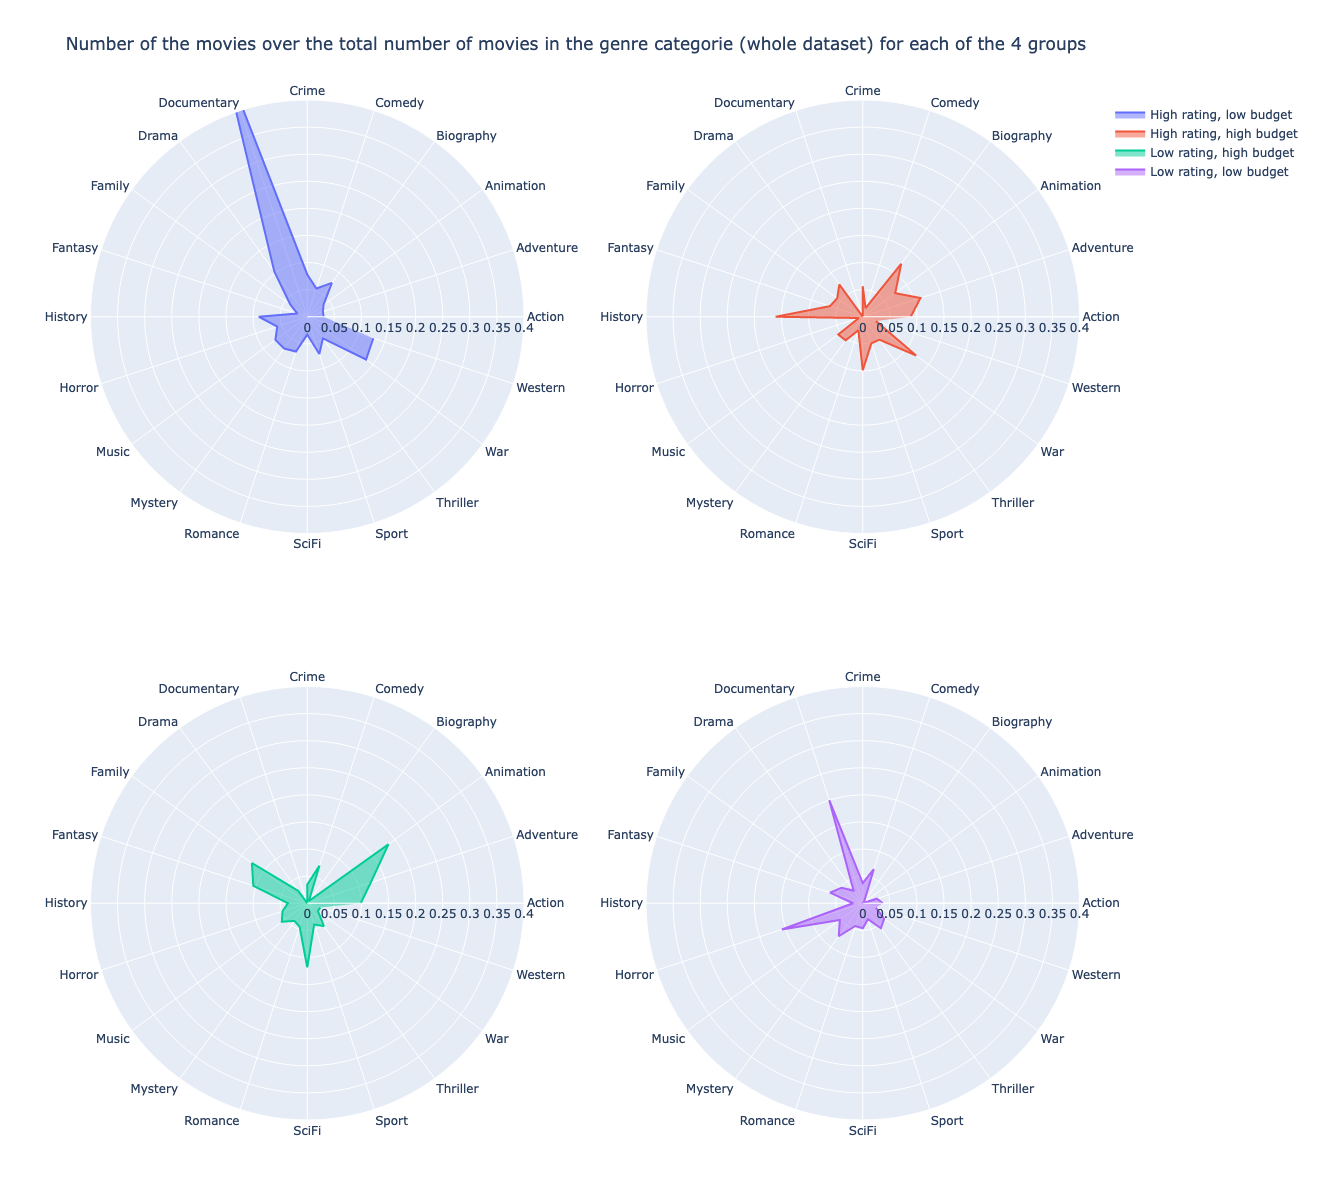

In [261]:
categories = data_HR_LB_genres.columns.values

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)

# Total count of the genres to normalize the count of the 4 groups 
total_count = data.iloc[:,1:21].sum().values

fig.append_trace(go.Scatterpolar(r=data_HR_LB_genres.sum().values/total_count, theta=categories, fill='toself', name='High rating, low budget'), row=1, col=1)
fig.append_trace(go.Scatterpolar(r=data_HR_HB_genres.sum().values/total_count, theta=categories, fill='toself', name='High rating, high budget'), row=1, col=2)
fig.append_trace(go.Scatterpolar(r=data_LR_HB_genres.sum().values/total_count, theta=categories, fill='toself', name='Low rating, high budget'), row=2, col=1)
fig.append_trace(go.Scatterpolar(r=data_LR_LB_genres.sum().values/total_count, theta=categories, fill='toself', name='Low rating, low budget'), row=2, col=2)
            
fig.update_polars(radialaxis=dict(range=[0, 0.4]))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
    width=1300,
    height=1200,
  showlegend=True,
    title_text = 'Number of the movies over the total number of movies in the genre categorie (whole dataset) for each of the 4 groups'
)

fig.show("jupyterlab")

The fraction represented in these graphics are over the total number of movies of a particular genre in the whole dataset. It is why the fraction are small, because the 4 groups do not contain all the data. 

We can see that for :
* high rating - low budget categorie there are more documentary, western, war movies.
* high rating - high budget categorie there are more biography, history movies. There also several adventure, sci-fi and war movies, but less than the other categories
* low rating - high budget categorie there are more animation, scifi, fantansy, family and action movies.
* low rating - low budget categorie there are more horror. There are also several documentaries, but less than the other categories

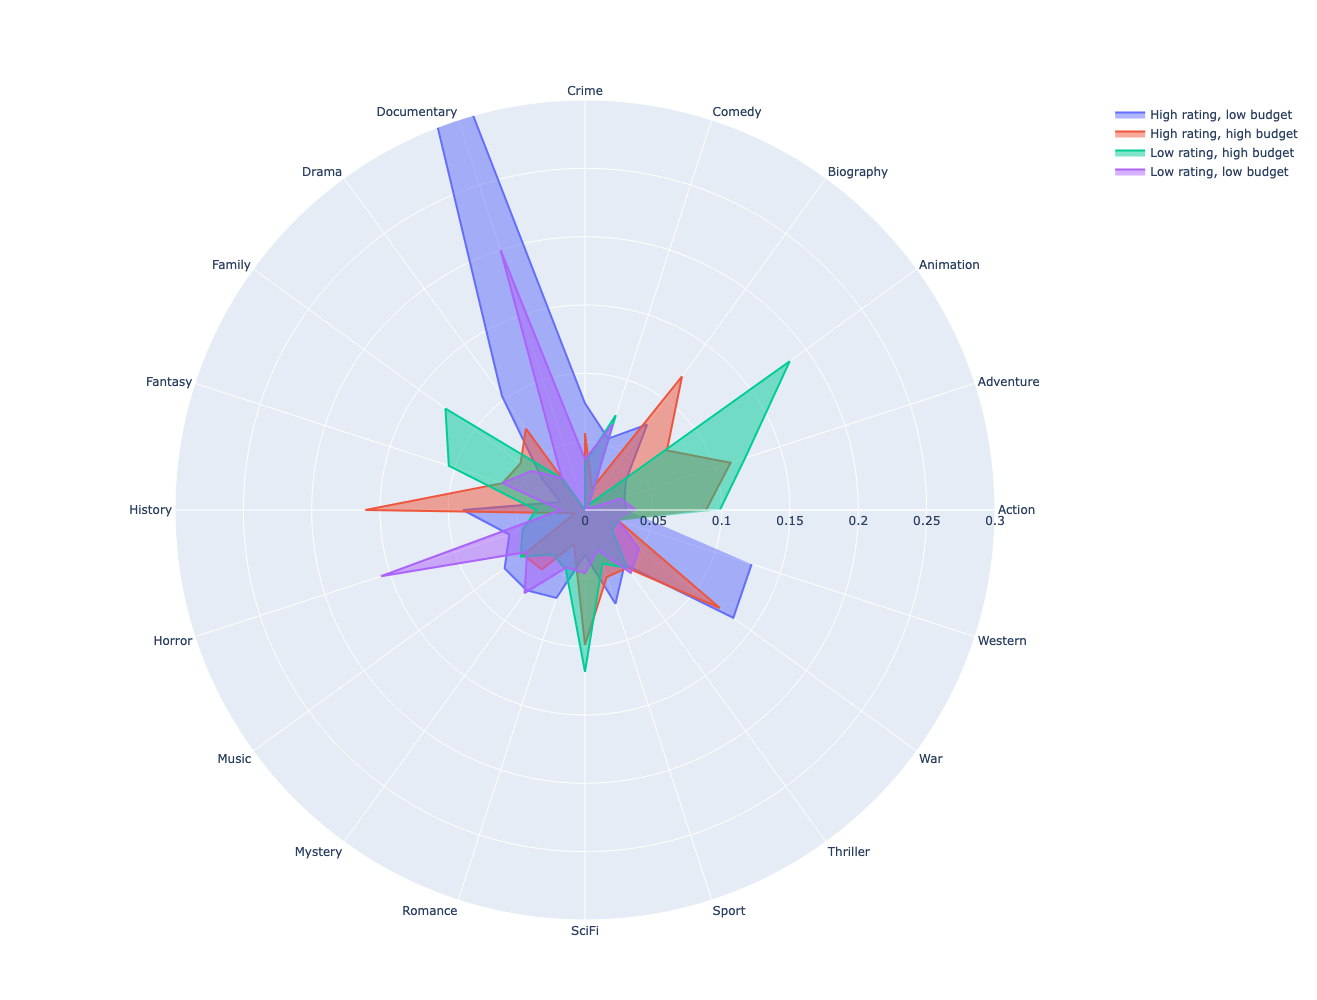

In [262]:
categories = data_HR_LB_genres.columns.values

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=data_HR_LB_genres.sum().values/total_count,
      theta=categories,
      fill='toself',
      name='High rating, low budget'
))
fig.add_trace(go.Scatterpolar(
      r=data_HR_HB_genres.sum().values/total_count,
      theta=categories,
      fill='toself',
      name='High rating, high budget'
))

fig.add_trace(go.Scatterpolar(
      r=data_LR_HB_genres.sum().values/total_count,
      theta=categories,
      fill='toself',
      name='Low rating, high budget'
))

fig.add_trace(go.Scatterpolar(
      r=data_LR_LB_genres.sum().values/total_count,
      theta=categories,
      fill='toself',
      name='Low rating, low budget'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 0.3]
    )),
    width=1000,
    height=1000,
  showlegend=True
)

fig.show('jupyterlab')

Then, we can observe the production countries in the same manner (columns 21 to 35) :

In [263]:
data_HR_LB_countries = data_HR_LB.iloc[:,21:36]
data_HR_HB_countries = data_HR_HB.iloc[:,21:36]
data_LR_HB_countries = data_LR_HB.iloc[:,21:36]
data_LR_LB_countries = data_LR_LB.iloc[:,21:36]

In [ ]:
#total_count = data_HR_LB_countries.sum().values + data_HR_HB_countries.sum().values + data_LR_HB_countries.sum().values + data_LR_LB_countries.sum().values

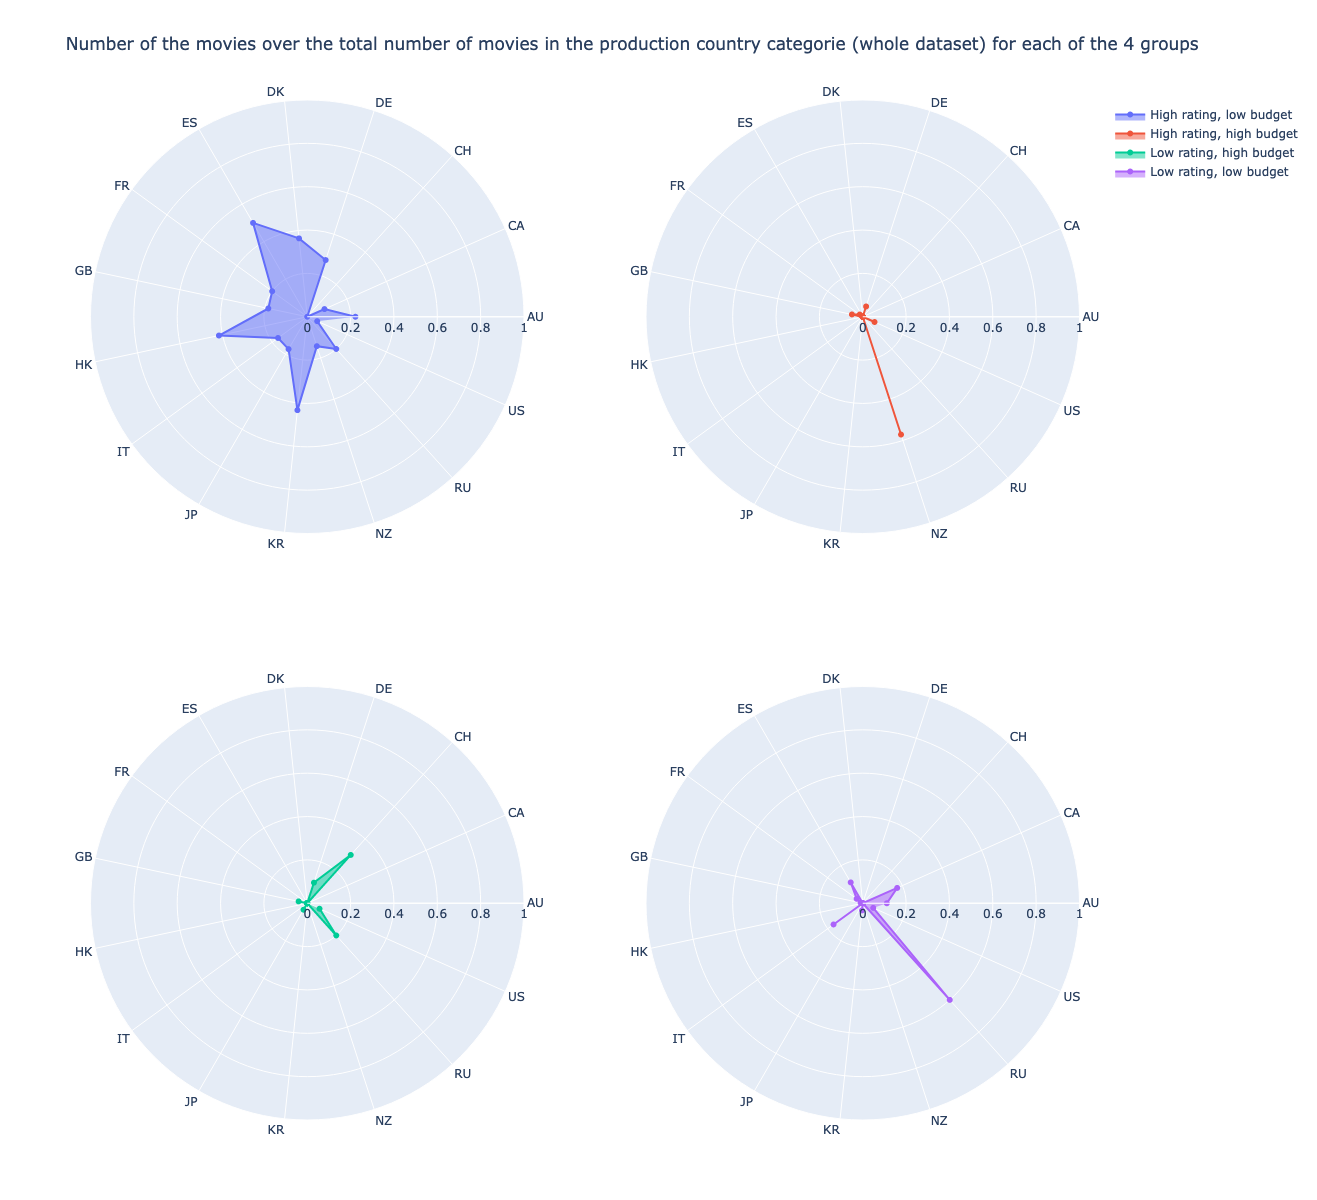

In [264]:
categories = data_HR_LB_countries.columns.values

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)

# Total count of the genres to normalize the count of the 4 groups 
total_count = data.iloc[:,21:36].sum().values

fig.append_trace(go.Scatterpolar(r=data_HR_LB_countries.sum().values/total_count, theta=categories, fill='toself', name='High rating, low budget'), row=1, col=1)
fig.append_trace(go.Scatterpolar(r=data_HR_HB_countries.sum().values/total_count, theta=categories, fill='toself', name='High rating, high budget'), row=1, col=2)
fig.append_trace(go.Scatterpolar(r=data_LR_HB_countries.sum().values/total_count, theta=categories, fill='toself', name='Low rating, high budget'), row=2, col=1)
fig.append_trace(go.Scatterpolar(r=data_LR_LB_countries.sum().values/total_count, theta=categories, fill='toself', name='Low rating, low budget'), row=2, col=2)
            
fig.update_polars(radialaxis=dict(range=[0, 1]))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
    width=1300,
    height=1200,
  showlegend=True,
    title_text = 'Number of the movies over the total number of movies in the production country categorie (whole dataset) for each of the 4 groups'
)

fig.show('jupyterlab')

The fraction represented in these graphics are over the total number of movies of a particular production country in the whole dataset. It is why the fraction are small, because the 4 groups do not contain all the data. 

We can see that for :
* high rating - low budget categorie there are more movies from DE, DK, ES, HK, KR than in the other categories, and the fraction around 0.5 so, it means nearly the majority of movies of the categorie.
* high rating - high budget categorie there are more from NZ.
* low rating - high budget categorie there are more from CH.
* low rating - low budget categorie there are more from RU.

It is interesting to see that in none of the categories the major production country (USA) has no peak. It is more non usual production countries that appear in the categories. We can see that DE, DK, ES, HK, KR has a good potential to produce cheap and good movies.

Then, we can also observe the actor attributes in the same manner (columns 38 to 40) :

In [265]:
data_HR_LB_actor = data_HR_LB.iloc[:,38:41]
data_HR_HB_actor = data_HR_HB.iloc[:,38:41]
data_LR_HB_actor = data_LR_HB.iloc[:,38:41]
data_LR_LB_actor = data_LR_LB.iloc[:,38:41]

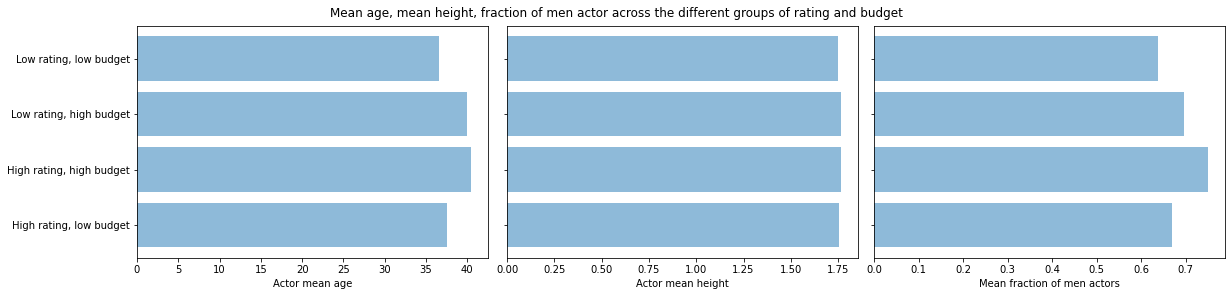

In [266]:
fig, ax = plt.subplots(1,3,constrained_layout=True, figsize=(17, 4), sharey=True)


ax[0].barh(['High rating, low budget', 'High rating, high budget', 'Low rating, high budget', 'Low rating, low budget'], \
         [data_HR_LB_actor['mean_age'].mean(), data_HR_HB_actor['mean_age'].mean(), data_LR_HB_actor['mean_age'].mean(), \
          data_LR_LB_actor['mean_age'].mean()], alpha=0.5)
ax[0].set_xlabel('Actor mean age')

ax[1].barh(['High rating, low budget', 'High rating, high budget', 'Low rating, high budget', 'Low rating, low budget'], \
         [data_HR_LB_actor['mean_height'].mean(), data_HR_HB_actor['mean_height'].mean(), data_LR_HB_actor['mean_height'].mean(), \
          data_LR_LB_actor['mean_height'].mean()], alpha=0.5)
ax[1].set_xlabel('Actor mean height')

ax[2].barh(['High rating, low budget', 'High rating, high budget', 'Low rating, high budget', 'Low rating, low budget'], \
         [data_HR_LB_actor['fraction_men'].mean(), data_HR_HB_actor['fraction_men'].mean(), data_LR_HB_actor['fraction_men'].mean(), \
          data_LR_LB_actor['fraction_men'].mean()], alpha=0.5)
ax[2].set_xlabel('Mean fraction of men actors')

plt.suptitle('Mean age, mean height, fraction of men actor across the different groups of rating and budget')
plt.show()

Here, the 'mean_age' column represents the mean age of actor per movie and took the mean across all the movies for each of the 4 categories of rating-budget. We did the same for the 'mean height'. We also computed the mean fraction of men actors across the movies for each categories.

We can see that for :
* the actor mean age, the high rating - low budget categorie has the lowest value. There is in general a lowest mean age for movies with low budget.
* the actor mean height, there are not much differences. The high rating - low budget categorie have a slightly lower mean height compare to the other 3 categories
* the mean fraction of men actors, the high rating - low budget categorie has the lowest value. There is in general a lowest mean age for movies with low budget. 

In summary, the high rating - low budget movies have a lower actor mean age, a slightly lower actor mean height and a lower fraction of men than the other categories.


We can also see if in the high rating - low budget there are a temporal difference as we did in the genre analysis :

In [267]:
def add_date(x) :
    return df_movie.loc[x]['Movie release date']

data_HR_LB['date'] = data_HR_LB.index.map(lambda x : add_date(x)).values

# split data in two periods: from 1959 to 2000 and from 2000 to 2021.
old_movies_HR_LB = data_HR_LB[data_HR_LB.date < 2000]
recent_movies_HR_LB = data_HR_LB[data_HR_LB.date >= 2000]

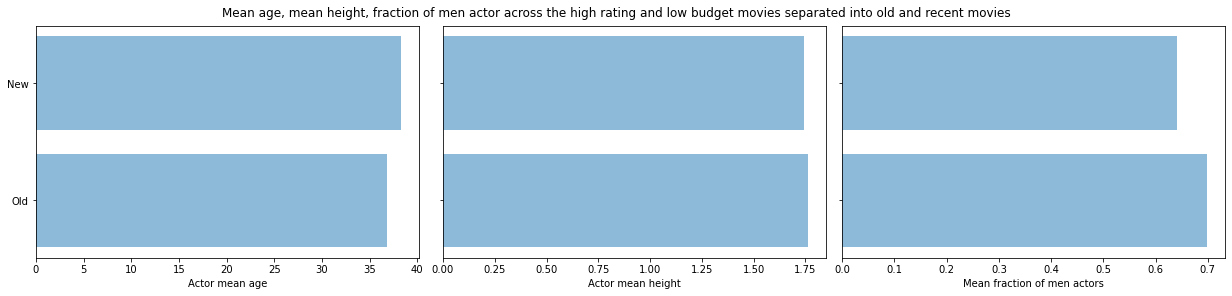

In [268]:
fig, ax = plt.subplots(1,3,constrained_layout=True, figsize=(17, 4), sharey=True)

ax[0].barh(['Old', 'New'], \
         [old_movies_HR_LB['mean_age'].mean(), recent_movies_HR_LB['mean_age'].mean()], alpha=0.5)
ax[0].set_xlabel('Actor mean age')

ax[1].barh(['Old', 'New'], \
         [old_movies_HR_LB['mean_height'].mean(), recent_movies_HR_LB['mean_height'].mean()], alpha=0.5)
ax[1].set_xlabel('Actor mean height')

ax[2].barh(['Old', 'New'], \
         [old_movies_HR_LB['fraction_men'].mean(), recent_movies_HR_LB['fraction_men'].mean()], alpha=0.5)
ax[2].set_xlabel('Mean fraction of men actors')

plt.suptitle('Mean age, mean height, fraction of men actor across the high rating and low budget movies separated into old and recent movies')
plt.show()

It seems to have a tendency in the new movies that have high rating and low budget to have older and more female actors than in the old movies of this categorie.

### 3) PCA

Before doing PCA, we have to standardize some features to have all the features in the same range of values :

In [269]:
def standardize(data):
    return (data - np.nanmean(data)) / np.std(data)

data['log_budget'] = standardize(data['log_budget'])
data['log_revenue'] = standardize(data['log_revenue'])
data['averageRating'] = standardize(data['averageRating'])
data['mean_age'] = standardize(data['mean_age'])
data['mean_height'] = standardize(data['mean_height'])
data['fraction_men'] = standardize(data['fraction_men'])

Now, we can perform dimensionality reduction :

In [272]:
pca = decomposition.PCA(n_components=10)
pca.fit(data.T)

PCA(n_components=10)

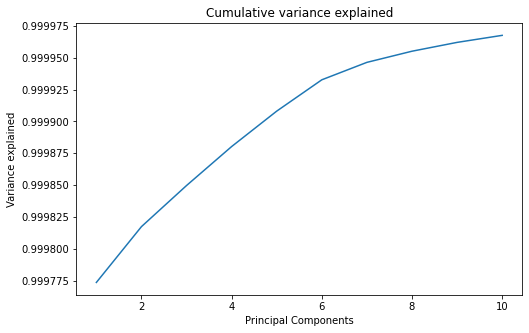

In [273]:
# compute cumulative explained variance
plt.figure(figsize=(8,5))
plt.title('Cumulative variance explained')
sns.lineplot(x = np.arange(1,11,1), y = np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Variance explained')
plt.show()

With 10 components, we can capture 90% of the variance in the data, but we already capture 80% with 8 components.
Let's observe some 2D principal components plots.

In [274]:
def plot_components(comp, color = None, alpha = None):
    if color is None : color = 'darkgreen'
    fig, axs = plt.subplots(ncols=3, figsize=(10,5), layout="constrained")
    axs[0].scatter(comp[0,:], comp[1,:], c = color, alpha = alpha)
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[1].scatter(comp[0,:], comp[2,:], c = color, alpha = alpha)
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC3')
    axs[2].scatter(comp[1,:], comp[2,:], c = color, alpha = alpha)
    axs[2].set_xlabel('PC2')
    axs[2].set_ylabel('PC3')
    plt.suptitle('Principal components subplots')
    plt.show()

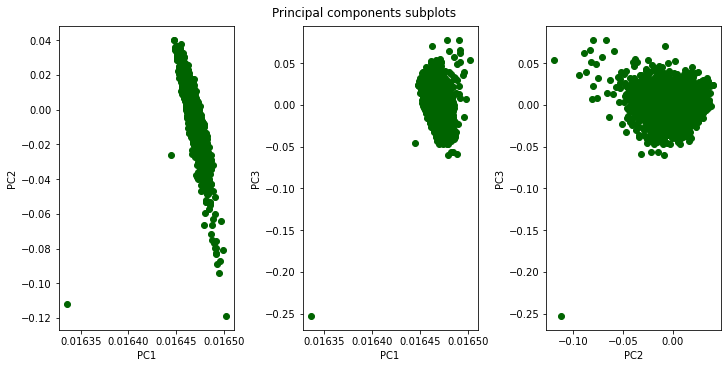

In [275]:
plot_components(pca.components_)

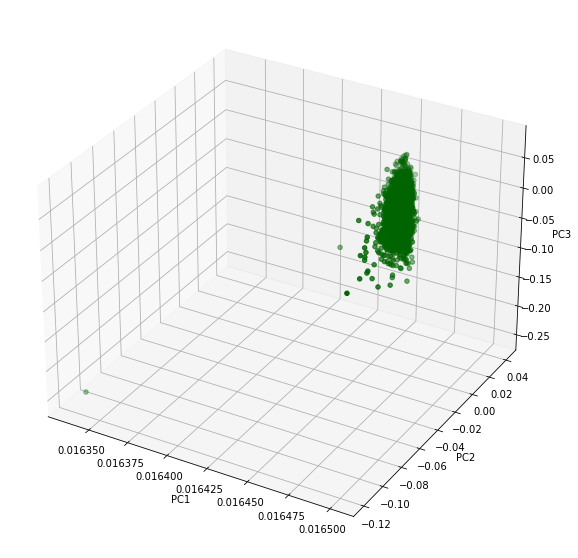

In [276]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')

ax.scatter(pca.components_[0,:], pca.components_[1,:], pca.components_[2,:], color = 'darkgreen')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### 4) K-means 

In [277]:
def silhouette(data, labels):
    """ Returns silhouette score of data [n_samples x n_features]"""
    return sklearn.metrics.silhouette_score(data, labels=labels)

def plot_silhouettes(x, silhouettes, param, clustering_type, n_clusters = None):
    """ Plot silhouette score """
    fig, ax = plt.subplots()
    ax.plot(x, silhouettes)
    if n_clusters is not None:
        for n, x_, y_ in zip(n_clusters, x, silhouettes):
            ax.text(x_, y_, str(n) + ' cl.', fontsize = 12)
    fig.suptitle(f'Silhouette score on clustering method: {clustering_type}')
    ax.set_xlabel(param)
    ax.set_ylabel('Silhouette score')
    plt.show()

In [278]:
n_comp = 8
PCs = pca.components_[:n_comp,:].T
N_list = np.arange(2,11,1)
kmeans_silhouettes = list()

for n in N_list:
    kmeans = KMeans(n_clusters=n, random_state=0).fit(PCs)
    kmeans_silhouettes.append(silhouette(data, kmeans.labels_))

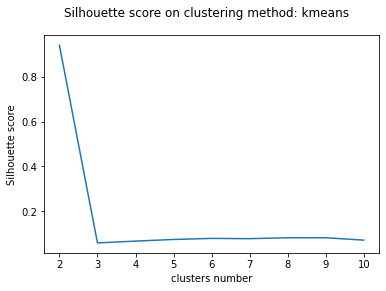

In [279]:
plot_silhouettes(N_list, kmeans_silhouettes, 'clusters number', 'kmeans')

### 5) DBSCAN

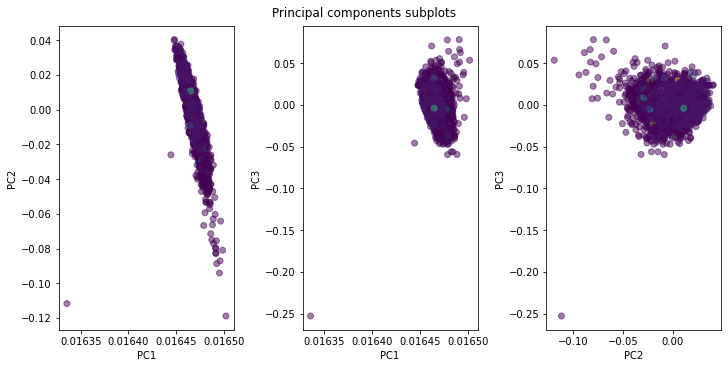

In [280]:
dbscan = DBSCAN(0.015, min_samples = 3).fit(PCs)
plot_components(PCs.T, color = dbscan.labels_, alpha=0.5)